## [Lecture 7.1: Softmax Regression with MNIST](https://www.youtube.com/watch?v=_zWJhbFQBQI)

### Overview
The objective of this notebook is to demonstrate softmax regression in classification task

> We make use of MNIST dataset for multi-class classification of images into the digits they represent.

### Import
Let's import necessary libraries for data loading, preprocessing, model training, selection and evaluation.

In addition, we also import basic python libraries for data handling and plotting.

We set the random seed to 42.

In [1]:
# Common imports
import numpy as np
from pprint import pprint

# To make this notebook's output stable across runs
np.random.seed(42)

# sklearn specific imports
# Data fetching
from sklearn.datasets import fetch_openml

# Feature scaling
from sklearn.preprocessing import StandardScaler

# Pipeline utility
from sklearn.pipeline import Pipeline

# Classifiers: Logistic Regression (LogisticRegression)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Evaluation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# global settings
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

### Data Loading
Let's load the MNIST dataset for handwritten digit recognition from OpenML

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

We receive feature matrix and label vector after fetching the data.

### Training-Test Split
Just like earlier MNIST explorations, we use first 60000 examples for training and remaining 10000 examples for test.

In [3]:
X = X.to_numpy()
y = y.to_numpy()

x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Model building
We scale the input features with StandardScaler and use `LogisticRegression` estimator with `multi_class` parameter set up `multinomial` and using `sag_solver`.

In [4]:
pipe = Pipeline(steps=[('scaler', StandardScaler()),
                       ('logreg', LogisticRegression(multi_class='multinomial',
                                                     solver='sag'))])
pipe.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(multi_class='multinomial', solver='sag'))])

After training the model with the training feature matrix and labels, we learn model parameters

In [5]:
pipe[-1].coef_.shape

(10, 784)

In [6]:
pipe[-1].intercept_.shape

(10,)

In [7]:
pipe[-1].classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

### Model Evaluation
Let's get a classification report on the test set and also display the confusion matrix.

In [8]:
print(classification_report(y_test, pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       980
           1       0.96      0.98      0.97      1135
           2       0.94      0.90      0.92      1032
           3       0.91      0.91      0.91      1010
           4       0.92      0.94      0.93       982
           5       0.91      0.87      0.89       892
           6       0.93      0.95      0.94       958
           7       0.92      0.93      0.92      1028
           8       0.88      0.88      0.88       974
           9       0.91      0.91      0.91      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



Most of the classes have f1-score greater than 90% which is considered a good f1-score.

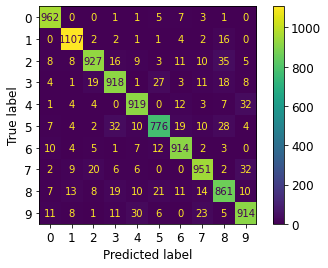

In [9]:
ConfusionMatrixDisplay.from_estimator(pipe, x_test, y_test)
plt.show()

### Using `LogisticRegressionCV`

In [ ]:
# Note training this model can take a lot of time (more than 2 hours) 
scorer = make_scorer(f1_score, average='micro')
pipe = Pipeline([('scaler', StandardScaler()),
                 ('logreg', LogisticRegressionCV(cv=5,
                                                 multi_class='multinomial',
                                                 solver='sag',
                                                 scoring=scorer,
                                                 max_iter=100,
                                                 random_state=1729))])
pipe.fit(x_train, y_train)

In [ ]:
pipe[-1].C_

In [ ]:
pipe[-1].l1_ratio_

In [ ]:
print(classification_report(y_test, pipe.predict(x_test)))

In [ ]:
ConfusionMatrixDisplay.from_estimator(pipe, x_test, y_test)
plt.show()

## [Lecture 7.3: KNN with MNIST](https://www.youtube.com/watch?v=nbOcdzyPulA)


### Imports
- Let's load all the usual functionalities and the classifier API `KNeighboursClassifier` from `sklearn.neighbours`

In [11]:
# Common imports
import numpy as np
from pprint import pprint
import statistics

# To make this notebook's output stable across runs
np.random.seed(42)

# sklearn specific imports
# Data fetching
from sklearn.datasets import fetch_openml

# Feature scaling
from sklearn.preprocessing import MinMaxScaler

# PCA
from sklearn.decomposition import PCA

# Pipeline utitlity
from sklearn.pipeline import Pipeline, make_pipeline

# Classifiers: Dummy, KNN
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

# Model selection
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.model_selection import learning_curve


# Evaluation
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score,recall_score
from sklearn.metrics import make_scorer

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import seaborn as sns

# global settings
mpl.rc('axes', labelsize=4)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', figsize=(8,6))

### Handwritten Digit Classification

### Dataset:
- Once again, we are going to use MNIST
- Each datapoint is contained in $x_i \in \mathbb{R}^{784}$ and the label $y_i \in \{0,1,2,3,4,5,6,7,8,9\}$

In [12]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [13]:
X = X.to_numpy()
y = y.to_numpy()

In [14]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### Binary Classification

### Change Labels to Binary
- Let's do a binary classification with KNN Classifier and eventually extend it to Multi-class set up

In [15]:
# initialize new variable names with all -1
y_train_0 =  -1 * np.ones((len(y_train)))
y_test_0 = -1 * np.ones((len(y_test)))

# find the indices of digit 0 image
indx_0 = np.where(y_train == '0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test == '0')
y_test_0[indx_0] = 1

### **Data Visualization in Lower Dimension**
- Let us apply PCA on the datapoints and reduce the dimensions to 2D and then to 3D.
- This will give us some rough idea about the points in $\mathbb{R}^{784}$
- One interesting thing to look at is the change in the magnitude of the data points before and after apply PCA.
- We use the variables `pipe_pca_2d` for preprocessing the samples alone and then `pipe_clf_pca_2d` for classification

In [16]:
pipe_pca_2d = make_pipeline(MinMaxScaler(), PCA(n_components=2))
x_train_pca_2d = pipe_pca_2d.fit_transform(x_train)

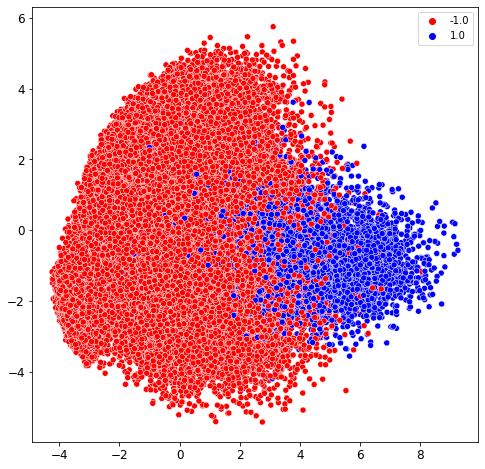

In [17]:
cmap = ListedColormap(['r', 'b'])
plt.figure(figsize=(8,8))
sns.scatterplot(x=x_train_pca_2d[:, 0], y=x_train_pca_2d[:,1], hue=y_train_0, palette=cmap)
plt.show()

### Projection in 3D using PCA

In [18]:
pipe_pca_3d = make_pipeline(MinMaxScaler(), PCA(n_components=3))
x_train_pca_3d = pipe_pca_3d.fit_transform(x_train)

In [19]:
import plotly.express as px

fig = px.scatter_3d(x=x_train_pca_3d[:,0],
                    y=x_train_pca_3d[:,1],
                    z=x_train_pca_3d[:,2],
                    color=y_train_0,
                    color_discrete_map=cmap,
                    opacity=0.5)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

### KNN Classifier

#### Algorithm
1. Set ***k*** to the desired value i.e how many neighbours should be allowed to participate in prediction.
2. Calculate the distance between the new example and every example from the data. Thus create a distance vector.
3. Get indices of nearest ***k*** neighbours
4. Get the labels of the selected ***k*** entries
5. If it is a classification task, return the majority class by computing mode of the ***k*** labels.


- To understand the working of sklearn built-in functions, we first create a KNN-classifier model with $k=3$ and consider a small number of samples from the training and testing set.
- The `KNeigborClassifier` creates a classifier instance. There are many optional arguments such as `n_neighbors, metric, weights,...` that can be set to suitable values while creating an instance.

In [20]:
# creating a new pipeline for classifier
pipe_clf_pca_2d = make_pipeline(pipe_pca_2d, KNeighborsClassifier(n_neighbors=3))

- Let us train the model with 10 samples from the training set(i.e we are just putting 10 datapoints in the metric space, not building any paramterized model).
- Then test the model with 10 datapoints from test set.

In [21]:
index_neg = np.argsort(y_train_0)[:5] # index of positive samples
index_pos = np.argsort(y_train_0)[-1:-6:-1] # index of negative samples

#### Sanity check

In [22]:
# Ensure that first 10 are a mix of both classes
print('Positive classes', y_train_0[index_pos])
print('Negative classes', y_train_0[index_neg])

Positive classes [1. 1. 1. 1. 1.]
Negative classes [-1. -1. -1. -1. -1.]


In [23]:
# create a small dataset
x = np.vstack((x_train[index_pos, :], x_train[index_neg,:]))
print(x.shape)
y = np.hstack((y_train_0[index_pos], y_train_0[index_neg]))
print(y.shape)

(10, 784)
(10,)


In [24]:
# For visualization
x_reduced = pipe_clf_pca_2d[0].transform(x)

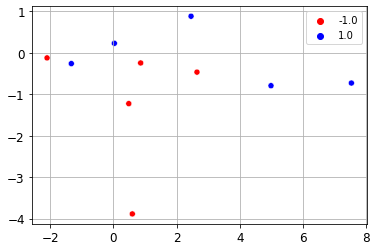

In [25]:
cmap = ListedColormap(['r', 'b'])
plt.figure(figsize=(6,4))
sns.scatterplot(x=x_reduced[:, 0], y=x_reduced[:,1],marker='o', hue=y, palette=cmap)
plt.grid(True)
plt.show()

In [26]:
# Let us fit the model with the new training set
pipe_clf_pca_2d.fit(x, y)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

Test labels: [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]


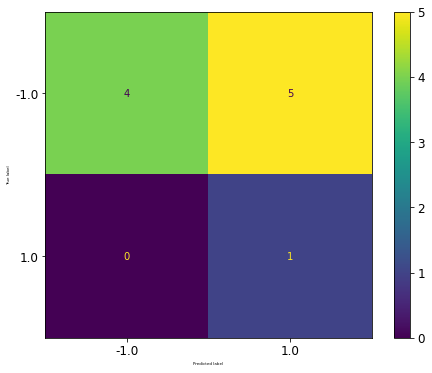

In [27]:
y_hat_0 = pipe_clf_pca_2d.predict(x_test[:10,:])
ConfusionMatrixDisplay.from_predictions(y_test_0[:10], y_hat_0)
print('Test labels:',y_test_0[:10])
plt.show()

- We can see that there are more FPs (Since 9 out of 10 actual labels are negative).
- Let us display both the training points and testing points with their predictions
- We can visually validate the reason behind the performance

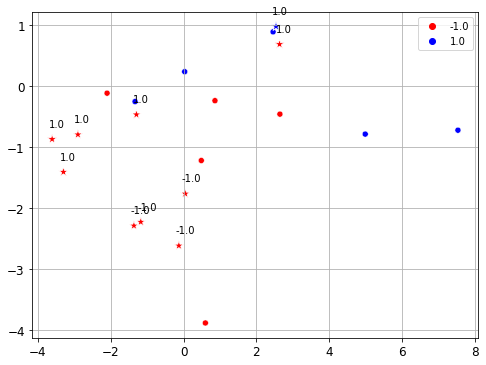

In [28]:
cmap = ListedColormap(['r', 'b'])
plt.figure(figsize=(8,6))
sns.scatterplot(x=x_reduced[:, 0], y=x_reduced[:,1],marker='o', hue=y, palette=cmap)

# test points
x_test_reduced = pipe_clf_pca_2d[0].transform(x_test[:10,:])
sns.scatterplot(x=x_test_reduced[:, 0], y=x_test_reduced[:,1],s=100,marker='*', hue=y_test_0[:10],palette=cmap, legend=None)

#Plot the test points and annotate their predictions
dx,dy =-0.1, 0.2
for i in range(10):
    plt.annotate(str(y_hat_0[i]), xy=(x_test_reduced[i,0]+dx, x_test_reduced[i,1]+dy))

plt.grid(True)
plt.show()

- It would be much better if we know the distance of 3 neighbours for each testing point.
- Let us display the distance and connectivity of neighbours to the test datapoints using the class `NearestNeighbors`.
- In fact `KNeighborsClassifier` calls `NearestNeighbors` class internally to compute all these distances.

In [29]:
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=3)
neighbors.fit(pipe_pca_2d.transform(x))

NearestNeighbors(n_neighbors=3)

Which are the first three closest neighbors to the first three in the test set? and how close are they?

In [30]:
dist_neighbors, idx_neighbors = neighbors.kneighbors(pipe_pca_2d.transform(x_test[:10]),
                                                     3,
                                                     return_distance=True)

In [31]:
for i in range(3):
    print('Distance : {0},\nIndex : {1}, \nLabels : {2} \nPredictions : {3}'.format(dist_neighbors[i],
                                                                                    idx_neighbors[i],
                                                                                    y[idx_neighbors[i].flatten()],
                                                                                    statistics.mode(y[idx_neighbors[i].flatten()])))

Distance : [1.54510433 1.56004731 1.61914472],
Index : [1 4 6], 
Labels : [ 1.  1. -1.] 
Predictions : 1.0
Distance : [0.95703587 3.33077652 3.39001596],
Index : [7 1 6], 
Labels : [-1.  1. -1.] 
Predictions : -1.0
Distance : [1.14297879 2.0379748  2.22709669],
Index : [6 4 1], 
Labels : [-1.  1.  1.] 
Predictions : 1.0


Let us train the model with 10000 samples from the training set (i.e we are putting 10000 datapoints in the metric space, not building any parameterized model).

In [32]:
pipe_clf_pca_2d.fit(x_train[:10000], y_train_0[:10000])

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                 ('pca', PCA(n_components=2))])),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

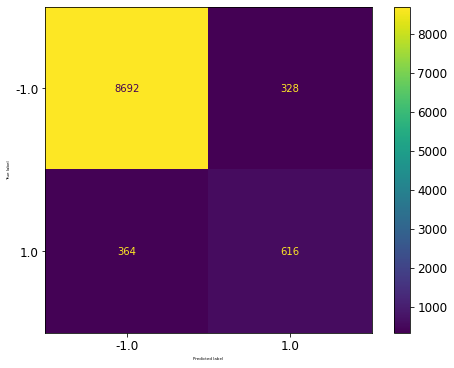

In [33]:
y_hat_0 = pipe_clf_pca_2d.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_0)
plt.show()

In [34]:
print(classification_report(y_test_0, y_hat_0))

              precision    recall  f1-score   support

        -1.0       0.96      0.96      0.96      9020
         1.0       0.65      0.63      0.64       980

    accuracy                           0.93     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.93      0.93      0.93     10000



- Let's  vary the `n_neighbors` from **k = 1 to 10** and study the performance of the model.
- We use the first 10k samples from the training set.

In [35]:
precision = []
for k in range(1, 20, 2):
    pipe_clf_pca_2d.__n_neighbors = k
    pipe_clf_pca_2d.fit(x_train[:10000], y_train_0[:10000])
    y_hat_0 = pipe_clf_pca_2d.predict(x_test)
    precision.append(precision_score(y_test_0, y_hat_0))


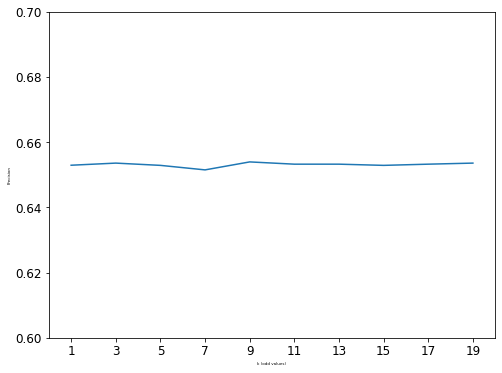

In [36]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, 20, 2), precision)
plt.xlim((0, 20))
plt.ylim((0.6, 0.7))
plt.xlabel('k (odd values)')
plt.ylabel('Precision')
plt.xticks(ticks= np.arange(1, 20, 2), labels = np.arange(1, 20 ,2))
plt.show()

### Going without PCA
- Let us use KNN classifier with all the features in the training samples. Hoping it would increase the performance of the model at the cost of computation.
- Let's search for K by using cross validation
- Note: It takes about 20 mins for complete computation

In [37]:
pipe_knn = make_pipeline(MinMaxScaler(),
                         KNeighborsClassifier(n_neighbors=1))


In [38]:
grid_k = {'kneighborsclassifier__n_neighbors': [1,3,5,7,9,11]}
cv = GridSearchCV(pipe_knn, param_grid = grid_k, scoring='precision', cv=5)
cv.fit(x_train, y_train_0)
print(cv)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_neighbors=1))]),
             param_grid={'kneighborsclassifier__n_neighbors': [1, 3, 5, 7, 9,
                                                               11]},
             scoring='precision')


In [39]:
print(cv.cv_results_)

{'mean_fit_time': array([0.4754653 , 0.479668  , 0.55075035, 0.55822334, 0.47819686,
       0.4841568 ]), 'std_fit_time': array([0.00295085, 0.0066376 , 0.13688944, 0.16886564, 0.00433452,
       0.01049871]), 'mean_score_time': array([29.83941212, 31.26619215, 36.39019985, 38.17191892, 35.07236071,
       35.06473742]), 'std_score_time': array([1.398915  , 0.38505642, 1.95353228, 3.53677414, 0.41340557,
       0.51164579]), 'param_kneighborsclassifier__n_neighbors': masked_array(data=[1, 3, 5, 7, 9, 11],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'kneighborsclassifier__n_neighbors': 1}, {'kneighborsclassifier__n_neighbors': 3}, {'kneighborsclassifier__n_neighbors': 5}, {'kneighborsclassifier__n_neighbors': 7}, {'kneighborsclassifier__n_neighbors': 9}, {'kneighborsclassifier__n_neighbors': 11}], 'split0_test_score': array([0.97920133, 0.98493724, 0.98166667, 0.98086522, 0.97921862,
       0.97921862]), 'sp

- The best value of k is 7.

In [40]:
pipe_knn = make_pipeline(MinMaxScaler(),
                         KNeighborsClassifier(n_neighbors=7))

### Performance on test set

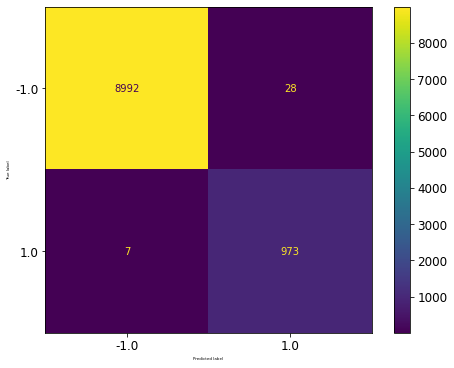

In [41]:
pipe_knn.fit(x_train, y_train_0)
y_hat_0 = pipe_knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_0)
plt.show()

### Multi Class Classification
- Extending KNN classifier to multi-class problem is quite straightforward.

In [42]:
print(pipe_knn)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=7))])


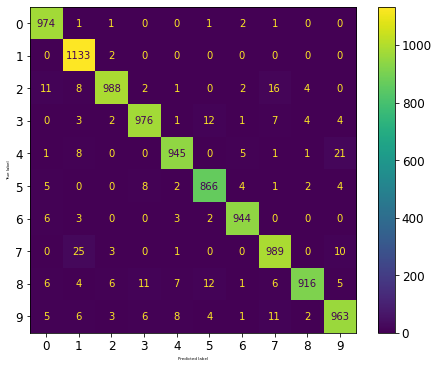

In [43]:
pipe_knn.fit(x_train, y_train)
y_hat = pipe_knn.predict(x_test)
ConfusionMatrixDisplay.from_predictions(y_test, y_hat)
plt.show()

In [44]:
pipe_knn.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [45]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.95      1.00      0.97      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## [Lecture 7.4: KNN with California Housing Dataset](https://www.youtube.com/watch?v=QCrEPEqkRII) 

### Overview
We know that k-NN can be used in addressing regression problems
In this notebook, we will demonstrate use of **k-NN in regression** setup with **California housing dataset**, where we try to predict price of a house based on its features.

### Importing libraries
We will import libraries that are needed for this demonstration.
- We need `sklearn` version later than 0.2 for this notebook to learn. We need to make sure that criteria met through `assert` statement.

In [46]:
# Scikit-learn >= 0.20  is required
import sklearn
assert sklearn.__version__ >= '0.20'

- We will import a few common libraries like `numpy` and `pandas` for manipulating the training data.
- We import `matplotlib.pyplot` for plotting purposes.

As far as the model development is concerned, we import the following libraries:
- For data loading, we import `fetch_california_housing` library.
- The data is split into training and test with `train_test_split` library
- For model building, we will make use of `pipeline` setup and hence we import `Pipeline` library.
- There are two stages in the pipeline, data preprocessing and estimator, we import `MinMaxScaler` library for preprocessing and `KNeighborsRegressor` estimator for regression problem.
- We will also experiment with polynomial features and for that we import `PolynomialFeatures` library.
- Number of neighbors $k$ is a hyper-parameter in k-NN and we show how to find it that through `GridSearchCV` and `RandomizedSearchCV` libraries.

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

### STEP 1: Training data
The first component in any ML system is the data. In this case, we will be using California housing dataset.

### Loading California housing dataset
For loading the data, we set `return_X_y` flag to `True`, which returns the dataset in form of feature matrix X and label vector y.

In [48]:
# Download the data
X, y = fetch_california_housing(return_X_y=True)

Let's check the shapes of feature matrix and label vectors.

In [49]:
print('Shape of feature matrix: ', X.shape)
print('Shape of label vector:', y.shape)

Shape of feature matrix:  (20640, 8)
Shape of label vector: (20640,)


There are 20640 examples in the dataset. Each example corresponds to one house and is represented with 8 features.

It is useful to perform a quick sanity check to make sure that we have equal number of rows in feature matrix and label vector.
> We make use of `assert` statement for that.

In [50]:
assert X.shape[0] == y.shape[0]

### Split the data into train and test sets
We will split the data into training and test sets.
> In this case, we set aside 30% examples as test and the remaining 70% examples are used for training the model.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=8)

In [52]:
print('Shape of training feature matrix', X_train.shape)
print('Shape of test feature matrix', X_test.shape)

Shape of training feature matrix (14448, 8)
Shape of test feature matrix (6192, 8)


There are 14448 examples in the training set and 6192 examples in the test set.

Let's make sure we have equal number of rows in the feature matrix and label vectors for both training and test sets.

In [53]:
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

### Preprocessing the dataset
We have explored california housing dataset in detail in the earlier weeks
In order to refresh your memory, we have histograms corresponding to all the features and the output label plotted here.

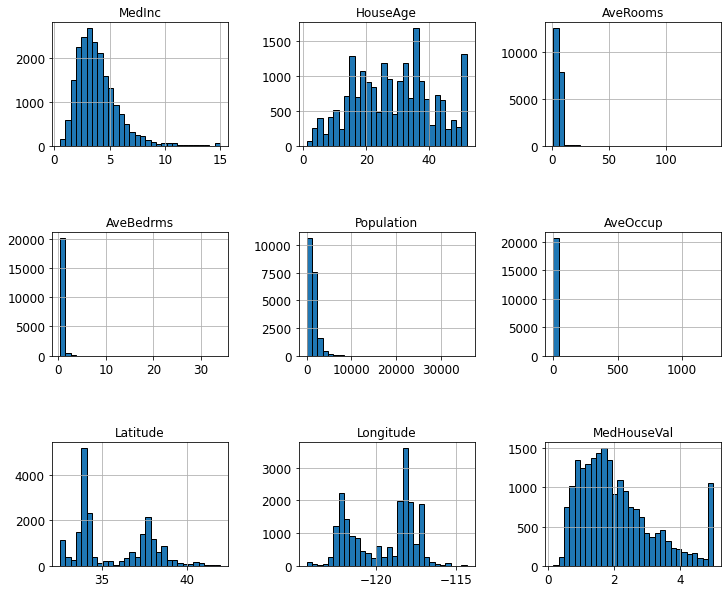

In [54]:
california_housing = fetch_california_housing(as_frame=True)
california_housing.frame.hist(figsize=(12,10), bins=30, edgecolor='black')
plt.subplots_adjust(hspace=0.7, wspace=0.4)

Observe that features are on different scale and we need to bring them on the same scale for k-NN
- k-NN uses distance computation to identify the nearest neighbors and it is crucial to have all the features on the same scale for that
- If all features are not on the same scale, The feature with wider variance could dominate the distance calculation

### STEP 2: Model Building
We instantiate a `pipeline` object with two steps.
- The first stage performs feature scaling with `MinMaxScaler`.
- And the second stage performs k-NN regressor with `n_neighbors=2`. In short we will be using 2-NN that is we use the price of the two nearest houses in feature space to decide the price of the new house.

The model is trained with feature matrix and the label vector from training set.

After the model is trained, it is evaluated with the test set using mean squared error metric.

In [55]:
# Create pipeline with min-max scaler followed by
# KNN regressor
pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=2))])

# fitting and transforming training data
pipe.fit(X_train, y_train)

# predict the test label vector from the test feature matrix
y_pred = pipe.predict(X_test)

# Compute RMSE
error = mean_squared_error(y_test, y_pred, squared=False)
print(error)

0.6767822465759739


### STEP 3: Model selection and evaluation
k-NN classifier has $k$ number of neighbors,as a hyper-parameter.

There are a couple of ways to tune the hyper-parameter:
1. Manual hyper-parameter tuning
2. Using `GridSearchCV` or `RandomizedSearchCV`

We demonstrate manual and grid search based hyper parameter tuning.

#### Manual HPT with cross-validation
Here we train and evaluate the model-pipeline with different values of $k$ from 1 to 30.

In [56]:
# to store rmse values for different values of k
rmse_val = []
for K in range(1, 31):

    pipe = Pipeline([('scaler', MinMaxScaler()),
                     ('knn', KNeighborsRegressor(n_neighbors=K))])
    # fit the model
    pipe.fit(X_train, y_train)

    # make prediction on test set
    y_pred = pipe.predict(X_test)

    # calculate rmse
    e = mean_squared_error(y_test, y_pred, squared=False)

    # store the rmse values
    rmse_val.append(e)

At the end of each loop, we get the list of all of RMSEs- one for each value of k.

We plot the learning curve  with k on x-axis and the RMSE on y-axis.
> The value of k that results in the lowesr RMSE is the best value of k that we select.

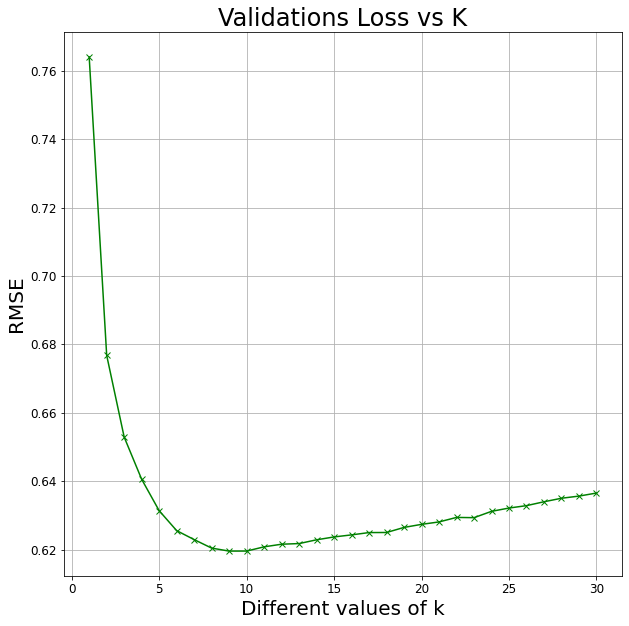

In [57]:
plt.figure(figsize=(10, 10))

# Plotting the rmse values against k values
plt.plot(range(1,len(rmse_val)+1), rmse_val, 'x-', color='green')
plt.xlabel('Different values of k', fontsize=20)
plt.ylabel('RMSE', fontsize=20)
plt.grid(True)

# displaying the title
plt.title('Validations Loss vs K', fontsize=24)

plt.show()

In [58]:
# index = np.argmin(rmse_val)
print('Lowest rmse values comes when K is :{}'.format(np.argmin(rmse_val)+1))

Lowest rmse values comes when K is :9


#### HPT with `GridSearchCV`
We setup the parameter grid for values of k of our interest.
> Here we use the value of k between 1 and 30.
The object of `GridSearchCV` is instantiated  with `KNeighborsRegressor` estimator along with the parameter grid and number of cross validation folds equal to 10.
The grid search is performed by calling the `fit` method with training features and labels as arguments

In [59]:
param_grid = {'knn__n_neighbors': list(range(1, 31))}

print(param_grid)

pipe = Pipeline([('scaler', MinMaxScaler()),
                 ('knn', KNeighborsRegressor())])

# Validate the model with these paramters
gs = GridSearchCV(estimator=pipe, param_grid=param_grid,
                  cv=10, n_jobs=-1,
                  return_train_score=True)

gs.fit(X_train, y_train)

reg_knn = gs.best_estimator_
print(reg_knn)

{'knn__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=6))])


After the model is trained, the best estimator can be obtained by accessing `best_estimator_` member variable of `GridSearchCV` object.

> In this case, we found the best KNN regressor to be 6-NN regressor

Let's evaluate the best estimator on the test set.

In [60]:
y_pred = gs.best_estimator_.predict(X_test)
error = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE of best value of k is:', error)

RMSE of best value of k is: 0.6255268557053962


**Exercise**: Perform hyperparameter search with `RandomizedSearchCV`.

#### Polynomial Features
In addition, we perform polynomial transformation on the features followed by scaling before using it in nearest neigbour regressor.

In [61]:
params = {'poly__degree':list(range(1,4)),
          'knn__n_neighbors': list(range(6,12))}
print(params)

pipe = Pipeline([('poly', PolynomialFeatures()),
                 ('scaler', MinMaxScaler()),
                 ('knn', KNeighborsRegressor())])
pipe = GridSearchCV(estimator=pipe,
                    param_grid=params,
                    cv=10, n_jobs=-1)

gs.fit(X_train, y_train)
reg_knn = gs.best_estimator_
print(reg_knn)

{'poly__degree': [1, 2, 3], 'knn__n_neighbors': [6, 7, 8, 9, 10, 11]}
Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=6))])


In [62]:
y_pred = gs.best_estimator_.predict(X_test)
error = mean_squared_error(y_test, y_pred, squared=False)
print('RMSE of best value of k is:', error)

RMSE of best value of k is: 0.6255268557053962


## [Lecture 7.5: Large Scale Machine Learning](https://www.youtube.com/watch?v=CodUuMNLHyc)

### Outline
In this colab, we study on how to handle **large-scale datasets** in sklearn.
- In this course, so far we were able to load **entire data in memory** and were able to train and make inferences on all the data at once.
- The large scale data sets may not fit in memory and we need to devise strategies to handle it in the context and prediction use cases.

In this colab, we will discuss the following topics:
> - Overview of handling large-scale data
> - Incremental preprocessing and learning
>  - `fit()` vs. `partial_fit()`: `partial_fit()` is our friend in this case.
> - Combining preprocessing and incremental learning 

### **Large-scale Machine Learning**
Large-scale Machine Learning differs from traditional machine learning in the sense that it involves processing large amount of data in terms of its **size** or **number of samples, features** or **classes**.

There were many exciting developments in efficient large scale learning on many real world use cases in the last decade.

Although scikit-learn  is optimized for **smaller data**, it does offer a decent of **feature preprocessing** and **learning algorithms** for large scale data such as classification, regression and clustering.

Scikit-learn handles large data through `partial_fit()` method instead of usual `fit()` method.

> The idea is to process the **data** in **batches** and **update** the model parameters for each batch. This way of learning is referred to as **'Incremental (or out of core) learning'**.

### Incremental Learning
Incremental learning may be required in the following two scenarios:
- For **out-of-memory (large) datasets**, where it's not possible to **load the entire data into the RAM** at once, one can load the data in chunks and fit the training model for each chunk of data.
- for machine learning tasks where a new batch of data comes with time, re-training the model with the previous and new batch of data is a computatitionally expensive process.
> Instead of re-training the model with entire set of data, one can employ a incremental learning approach, where the model parameters are updated with the new batch of data.

### Incremental Learning in `sklearn`
To perform incremental learning, Scikit-learn implements **partial-fit** method that helps in training an out-of-memory dataset. In other words, it has the ability to learn incrementally from the batches of instances.

In this notebook, we will see an example of how to read, process and train on such large dataset that can't loaded in memory entirely.

This method is expected to be called several times consecutively on different chunks of dataset so as to implement-out-of-core (online) learning. This function has some performance overhead, so it's recommended to call it on considerable large batch of data ( That fits into the memory) to overcome the limitation of overhead.

### `partial_fit()` attributes:
`partial_fit(X, y, [classes], [sample_weight])`
where,
- X : array of shape `(n_samples, n_features)` where `n_samples` is number of samples and `n_features` is the number of features.
- y : array of shape `(n_samples, )` containing a list of all the classes that can possibly appear in the y vector.
- `classes` : array of shape `(n_classes,)` containing a list of all the classes that can possibly appear in the y vector.

Must be provided  at the first call to `partial_fit()` can be omitted in subsequent calls.
- `sample_weight` : (optional) array of shape `(n_samples, )` containing  weights to be applied to individual samples (1. for unweighted)

Returns: `object(self)`

For classification tasks, we have to pass the list of possible target class labels in `classes` parameter to cope-up with the unseen target classes in the first batch of data.

The following estimators implement `partial_fit()` method:
- **Classification :**
 - `MultinomialNB`
 - `BernoulliNB`
 - `SGDClassifier`
 - `Perceptron`
- **Regression :**
 - `SGDRegressor`
- **Clustering :**
 - `MiniBatchKMeans`

`SGDRegressor` and `SGDClassifier` are commonly used for handling large data.

The problem with standard regresson/classification implementations such as batch gradient descent, support vector machines (SVMs), random forests etc. is  that because of the need to load all the data into memory at once, they can not be used in scenarios where we do not have sufficient memory. SGD, however can deal with large data sets effectively by breaking up the chunks and processing them sequentially. The fact that we need to load one chunk into memory at a time makes it useful for large scale data as well as cases where we get streams of data at intervals.


### **`fit() versus partial_fit()`**
Below, we show the use of `partial_fit()` along with `SGDClassifier` on the sample data.

For illustration, we first use traditional `fit()` method and then use `partial_fit()` on the same data.

In [63]:
# Importing Libraries
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 1. Traditional approach (using `fit()`)
#### Sample datasets
We will use a synthetic classification dataset for classification.

Let us have 50000 samples with 10 features in the feature matrix. Further, let's have 3 classes in the target label, each class having a single cluster.

In [64]:
x, y = make_classification(n_samples=50000, n_features=10,
                           n_classes=3,
                           n_clusters_per_class=1)
print(np.unique(y))
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.15)

[0 1 2]


We will make use of `SGDClassifier` to learn the classification model.

In [65]:
clf1 = SGDClassifier(max_iter=1000, tol=0.1)

Now we will use traditional `fit()` method to train our model.

In [66]:
clf1.fit(xtrain, ytrain)

SGDClassifier(tol=0.1)

Let's obtain the training and test scores on the trained model.

In [67]:
train_score = clf1.score(xtrain, ytrain)
print('Training score:', train_score)

Training score: 0.8626352941176471


In [68]:
test_score = clf1.score(xtest, ytest)
print('Testing score:', test_score)

Testing score: 0.8626666666666667


We obtain the confusion matrix and classification report for evaluating the classifier

In [69]:
ypred = clf1.predict(xtest)

cm = confusion_matrix(ytest, ypred)
print(cm)

[[2230  232   71]
 [ 223 2023  211]
 [  73  220 2217]]


We use `classification_report` API for obtaining important evaluation metrics for all three classes.

In [70]:
cr = classification_report(ytest, ypred)
print(cr)

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      2533
           1       0.82      0.82      0.82      2457
           2       0.89      0.88      0.89      2510

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



### 2. Incremental approach (using `partial_fit()`)
We will now assume that the data can not be kept completely in the main memory and hence, will load chunks of data and fit using `partial_fit()`

In [71]:
xtrain[0:5]

array([[-0.3606071 , -0.68588174,  1.28632054, -0.21809218, -0.49047757,
        -0.31929416, -2.25359204,  0.16101461,  0.81716835, -0.43509834],
       [-0.58650243,  0.86729199,  1.99468606, -0.55912808,  0.80290215,
        -0.05030629,  0.87555179,  1.43452821, -0.83261392, -1.39736255],
       [ 0.54665169,  0.9009529 , -1.44241257,  0.31612623, -0.05614861,
        -0.0797642 ,  0.09703217, -0.33145813, -0.90349841,  0.65773429],
       [-1.95072783, -1.28561972, -1.81990709,  0.9801144 ,  0.92139365,
         0.31424923,  0.46250232, -2.13528947,  0.37256944,  2.34482484],
       [-0.13925583, -1.28477052,  0.10592912, -1.05827946, -0.28477242,
        -0.76851815,  0.42490472,  2.36851621, -0.58261345, -2.54919042]])

In [72]:
ytrain[0:5]

array([0, 2, 1, 1, 2])

In order to load chunk by chunk, we will first store the given (training) data in csv file (This is just for demonstration purposes. In a real scenario, the large dataset might be already in a form of say, a csv, which we will be reading in multiple iterations).

In [73]:
import numpy as np

In [74]:
train_data = np.concatenate((xtrain, ytrain[:, np.newaxis]), axis=1)

In [75]:
train_data[:5]

array([[-0.3606071 , -0.68588174,  1.28632054, -0.21809218, -0.49047757,
        -0.31929416, -2.25359204,  0.16101461,  0.81716835, -0.43509834,
         0.        ],
       [-0.58650243,  0.86729199,  1.99468606, -0.55912808,  0.80290215,
        -0.05030629,  0.87555179,  1.43452821, -0.83261392, -1.39736255,
         2.        ],
       [ 0.54665169,  0.9009529 , -1.44241257,  0.31612623, -0.05614861,
        -0.0797642 ,  0.09703217, -0.33145813, -0.90349841,  0.65773429,
         1.        ],
       [-1.95072783, -1.28561972, -1.81990709,  0.9801144 ,  0.92139365,
         0.31424923,  0.46250232, -2.13528947,  0.37256944,  2.34482484,
         1.        ],
       [-0.13925583, -1.28477052,  0.10592912, -1.05827946, -0.28477242,
        -0.76851815,  0.42490472,  2.36851621, -0.58261345, -2.54919042,
         2.        ]])

In [76]:
a = np.asarray(train_data)
np.savetxt('train_data.csv', a, delimiter=',')

Now our data for demonstration is ready in a csv file.
Let's create `SGDClassifier` object that we intend to train with `partial_fit`.

In [77]:
# Let us create another classifier and we will fit it incrementally.
clf2 = SGDClassifier(max_iter=1000, tol=0.01)

### Processing data chunk by chunk
Pandas `read_csv()` function has an attribute `chunksize` that can be used to read data chunk by chunk. The `chunksize` parameter specifies the number of rows per chunk. (The last chunk may contain fewer than chunksize rows)

We can then use this data for `partial_fit()`. We can then repeat these two steps multiple times . That way, the entire data may not be required to be kept in memory.

In [78]:
import pandas as pd

chunksize = 1000

iter = 1
for train_df in pd.read_csv('train_data.csv', chunksize=chunksize, iterator=True):

    if iter == 1:
        # In the first iteration, we are specifying all possible class labels
        xtrain_partial = train_df.iloc[:, 0:10]
        ytrain_partial = train_df.iloc[:, 10]
        clf2.partial_fit(xtrain_partial, ytrain_partial,
                         classes=np.array([0, 1, 2]))
    else:
        xtrain_partial = train_df.iloc[:, 0:10]
        ytrain_partial = train_df.iloc[:, 10]
        clf2.partial_fit(xtrain_partial, ytrain_partial)
    
    print('After iter #', iter)
    print(clf2.coef_)
    print(clf2.intercept_)
    iter = iter + 1

After iter # 1
[[-2.75723881e+00  3.98910860e+00  6.50820408e+00  3.48718421e-02
   6.52720607e+00  1.17744099e+01 -1.46323244e+01 -1.09148229e+01
   3.10702523e+01  3.07381290e+00]
 [-1.25737487e+00 -2.16592347e+00  1.35077528e+01  1.43858531e+01
   8.81942163e+00 -2.37019073e+00 -4.47509379e+00 -2.63067953e+01
  -8.95680782e+00  3.30277354e+01]
 [-3.14258596e+00  1.03015513e+01 -5.97487981e+00 -6.03583793e+00
   5.79683297e+00  3.28198042e+00  2.98352209e+00  2.92001496e+01
  -4.82842471e+01 -1.88683592e+01]]
[-23.70318347  -4.04622613 -90.34785185]
After iter # 2
[[ -2.97387251   6.64398379  -4.50905047  -6.85282957  -1.56518674
   -1.5821382   12.11427114   3.72737394  29.49340685 -13.30404796]
 [ -4.16632142  -9.85292552 -11.74820337   8.95898716  -7.91121499
   -3.78302811  -7.32292708 -19.06519804   2.10767269  21.30850281]
 [  2.92940841   8.51110838  11.69017776  -6.40617725   3.30235791
    5.85945296  -1.52999827  22.33661465 -26.44682888 -17.63814384]]
[-16.2844654  -18.041

**Notes**:
- In the first call to `partial_fit()`, we passed the list of possible target class labels. For subsequent calls to `partial_fit()`, this is not required.
- Observe the changing values pf the classifier attributes: `coef_` and `intercept_` which we are printing in each iteration.



In [79]:
test_score = clf2.score(xtest, ytest)
print('Test Score:', test_score)

Test Score: 0.8576


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but SGDClassifier was fitted with feature names



Let's evaluate the classifier by examining the `confusion_matrix`

In [80]:
ypred = clf2.predict(xtest)
cm = confusion_matrix(ytest, ypred)
print(cm)

[[2228  200  105]
 [ 282 1944  231]
 [  48  202 2260]]


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning:

X does not have valid feature names, but SGDClassifier was fitted with feature names



In [81]:
cr = classification_report(ytest, ypred)
print(cr)

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      2533
           1       0.83      0.79      0.81      2457
           2       0.87      0.90      0.89      2510

    accuracy                           0.86      7500
   macro avg       0.86      0.86      0.86      7500
weighted avg       0.86      0.86      0.86      7500



Apart from `SGDClassifier()`, we can also train `Perceptron(), MultinomialNB()` and `BernoulliNB()` in a similar manner.

### **Incremental Preprocessing Example**


#### `CountVectorizer` vs `HashingVectorizer`

Vectorizer are used to convert a collection of text documents to a vector representation, thus helping in preprocessing them before applying any model on these text documents.

`CountVectorizer` and `HashingVectorizer` both perform the task of vectorizing the text documents. However, there are some differences among them.

One difference is that `HashingVectorizer` does not store the resulting vocabulary (i.e unique tokens). Hence it can be used to learn from data that does not fit into the computer's main memory. Each mini-batch is vectorized using `HashingVectorizer` so as to guarantee that the input space of the estimator has always the same dimensionality

With `HashingVectorizer`, each token directly maps to a pre-defined column position in a matrix. For example, if there are 100 columns in the resultant (vectorizer) matrix, each token (word) maps to 1 of the 100 columns. The mapping between the word and the position in matrix is done using hashing.

In other words, in `HashingVectorizer`, each token transforms to a column position of adding to the vocabulary. Not storing the vocabulary is useful while handling the large datasets. This is because holding a huge token vocabulary comprising millions of words maybe a challenge when memory is limited.

Since `HashingVectorizer` does not store vocabulary, its object not only takes less space, it alleviates any dependence with function calls performed on the previous chunk of data in the case of incremental learning.

In [82]:
text_documents = ['The well-known saying an apple a day keeps the doctor away has a very straighforward, literal meaning, that the eating of fruit maintain good health.',
                  'The proverb first appeared in print in 1866 and over 150 years later is advice that we still pass down through generations.',
                  'British apples are one of the nations best loved fruit and according to Great British Apples, we consume around 122,000 tonnes of them each year.',
                  'But what are the health benefits, and do they really keep the doctor away?']

#### 1. `CountVectorizer`
We will first import the library and then create an object of CountVectorizer class.

In [83]:
from sklearn.feature_extraction.text import CountVectorizer
c_vectorizer = CountVectorizer()

We will now use this object to vectorize the input text documents using the function `fit_transform()`

In [84]:
X_c = c_vectorizer.fit_transform(text_documents)

In [85]:
X_c.shape

(4, 66)

Here 66 is the size of the vocabulary.
We can also see the vocabulary using `vocabulary_` attribute.

In [86]:
c_vectorizer.vocabulary_

{'000': 0,
 '122': 1,
 '150': 2,
 '1866': 3,
 'according': 4,
 'advice': 5,
 'an': 6,
 'and': 7,
 'appeared': 8,
 'apple': 9,
 'apples': 10,
 'are': 11,
 'around': 12,
 'away': 13,
 'benefits': 14,
 'best': 15,
 'british': 16,
 'but': 17,
 'consume': 18,
 'day': 19,
 'do': 20,
 'doctor': 21,
 'down': 22,
 'each': 23,
 'eating': 24,
 'first': 25,
 'fruit': 26,
 'generations': 27,
 'good': 28,
 'great': 29,
 'has': 30,
 'health': 31,
 'in': 32,
 'is': 33,
 'keep': 34,
 'keeps': 35,
 'known': 36,
 'later': 37,
 'literal': 38,
 'loved': 39,
 'maintain': 40,
 'meaning': 41,
 'nations': 42,
 'of': 43,
 'one': 44,
 'over': 45,
 'pass': 46,
 'print': 47,
 'proverb': 48,
 'really': 49,
 'saying': 50,
 'still': 51,
 'straighforward': 52,
 'that': 53,
 'the': 54,
 'them': 55,
 'they': 56,
 'through': 57,
 'to': 58,
 'tonnes': 59,
 'very': 60,
 'we': 61,
 'well': 62,
 'what': 63,
 'year': 64,
 'years': 65}

Following is the representation of four text documents.

In [87]:
print(X_c)

  (0, 54)	3
  (0, 62)	1
  (0, 36)	1
  (0, 50)	1
  (0, 6)	1
  (0, 9)	1
  (0, 19)	1
  (0, 35)	1
  (0, 21)	1
  (0, 13)	1
  (0, 30)	1
  (0, 60)	1
  (0, 52)	1
  (0, 38)	1
  (0, 41)	1
  (0, 53)	1
  (0, 24)	1
  (0, 43)	1
  (0, 26)	1
  (0, 40)	1
  (0, 28)	1
  (0, 31)	1
  (1, 54)	1
  (1, 53)	1
  (1, 48)	1
  :	:
  (2, 39)	1
  (2, 4)	1
  (2, 58)	1
  (2, 29)	1
  (2, 18)	1
  (2, 12)	1
  (2, 1)	1
  (2, 0)	1
  (2, 59)	1
  (2, 55)	1
  (2, 23)	1
  (2, 64)	1
  (3, 54)	2
  (3, 21)	1
  (3, 13)	1
  (3, 31)	1
  (3, 7)	1
  (3, 11)	1
  (3, 17)	1
  (3, 63)	1
  (3, 14)	1
  (3, 20)	1
  (3, 56)	1
  (3, 49)	1
  (3, 34)	1


#### 2. `HashingVectorizer`
Let us now see how `HashingVectorizer` is different from `CountVectorizer`
We will create an object of `HashingVectorizer`. While creating the object, we need to specify the number of features we wish to have in the feature matrix.

In [88]:
from sklearn.feature_extraction.text import HashingVectorizer

Let us create an object of `HashingVectorizer` class. An important parameter in this class is `n_features`. It declares the number of features (columns) in the output feature matrix.

Note: Small number of features are likely to cause hash collisions, but large numbers will cause larger coefficient dimensions in linear learners.

In [89]:
h_vectorizer = HashingVectorizer(n_features = 50)

Let's perform hashing vectorization  with `fit_transform`

In [90]:
X_h = h_vectorizer.fit_transform(text_documents)

Let us examine the shape of the transformed feature matrix. The number of columns in this matrix is equal to the `n_features` attribute we specified

In [91]:
X_h.shape

(4, 50)

Let's print the the representation of the first example.

In [92]:
print(X_h[0])

  (0, 5)	0.0
  (0, 8)	-0.4472135954999579
  (0, 10)	-0.22360679774997896
  (0, 11)	-0.22360679774997896
  (0, 13)	0.0
  (0, 16)	0.22360679774997896
  (0, 18)	-0.22360679774997896
  (0, 20)	0.22360679774997896
  (0, 21)	0.22360679774997896
  (0, 26)	0.0
  (0, 29)	0.22360679774997896
  (0, 33)	0.22360679774997896
  (0, 36)	-0.22360679774997896
  (0, 38)	0.22360679774997896
  (0, 39)	-0.22360679774997896
  (0, 45)	-0.4472135954999579
  (0, 46)	0.22360679774997896


Overall, `HashingVectorizer` is a good choice if we are falling short on of the memory and resources, or we need to perform incremental learning. However, `CountVectorizer` is a good choice if we need to access the actual tokens.

### **Combining preprocessing and fitting in Incremental Learning**
#### (`HashingVectorizer` along with `SGDClassifier`)
We will now use a dataset containing a textual feature that requires preprocessing using a vectorizer. Since we wish to perform incremental learning using `partial_fit()`, we will now preprocess (i.e vectorize) the dataset feature using `HashingVectorizer` and then we will incrementally fit it.

#### 1. Downloading the dataset.
Below we download a dataset from UCL ML datasets library. (Instead of downloading, unzipping and then reading the, we are directly reading the zipped csv file. For that purpose, we are making use of `urllib.request, BytesIO` and `TextIOWrapper` classes.)

This is a sentiment analysis dataset. There are only two columns in the dataset. One for textual review and the other for the sentiment.

In [93]:
import pandas as pd
from io import StringIO, BytesIO, TextIOWrapper
from zipfile import ZipFile
import urllib.request

resp = urllib.request.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip')
zipfile = ZipFile(BytesIO(resp.read()))

data = TextIOWrapper(zipfile.open('sentiment labelled sentences/amazon_cells_labelled.txt'), encoding='utf-8')
df = pd.read_csv(data, sep='\t')
df.columns=['review', 'sentiment']

#### 2. Exploring the dataset.
Let's explore the dataset a bit.

In [94]:
df.head()

,review,sentiment
0,"Good case, Excellent value.",1
1,Great for the jawbone.,1
2,Tied to charger for conversations lasting more...,0
3,The mic is great.,1
4,I have to jiggle the plug to get it to line up...,0


In [95]:
df.tail()

,review,sentiment
994,The screen does get smudged easily because it ...,0
995,What a piece of junk.. I lose more calls on th...,0
996,Item Does Not Match Picture.,0
997,The only thing that disappoint me is the infra...,0
998,"You can not answer calls with the unit, never ...",0


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     999 non-null    object
 1   sentiment  999 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 15.7+ KB


In [97]:
df.describe()

,sentiment
count,999.000000
mean,0.500501
std,0.500250
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [98]:
df.loc[:, 'sentiment'].unique()

array([1, 0])

As we can see,
- There are 999 samples in the dataset.
- The possible classes for sentiment are 1 and 0

#### 4. Splitting data into train and test

In [99]:
from sklearn.model_selection import train_test_split

In [100]:
X = df.loc[:, 'review']
y = df.loc[:, 'sentiment']

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [102]:
X_train.shape

(799,)

In [103]:
y_train.shape

(799,)

#### 5. Preprocessing
Since the data is textual, we need to vectorize it, in order to perform incremental learning. We will use `HashingVectorizer`.

In [104]:
from sklearn.feature_extraction.text import HashingVectorizer
vectorizer = HashingVectorizer()

#### 6. Creating an instance of the `SGDClassifier`

In [105]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(penalty='l2', loss='hinge')

#### 7. Iteration 1 of `partial_fit()`
We will assume we do not have sufficient memory to handle all the 799 samples in one go for training purpose. So, we will take the first 400 samples from the training data and `partial_fit()` our classifier.

Another use case of `partial_fit()` here could also be a scenario where we only have 400 samples available at a time. So we fit our classifier with them. However, we `partial_fit()` it, to have the possibility of training it with more data later whenever that becomes available.

In [106]:
X_train_part1_hashed = vectorizer.fit_transform(X_train[0:400])
y_train_part1 = y_train[0:400]

In [107]:
all_classes = np.unique(df.loc[:, 'sentiment']) # we need to mention all classes in the first iteration of partial_fit()

In [108]:
classifier.partial_fit(X_train_part1_hashed, y_train_part1, classes=all_classes)

SGDClassifier()

Let us now use this classifier on our test data that we had kept aside earlier.

In [109]:
X_test_hashed = vectorizer.transform(X_test) # first we will have to preprocess the X_test with the same vectorizer 
                                             # that was fit on the training data


In [110]:
test_score = classifier.score(X_test_hashed, y_test)
print('Test score: ', test_score)

Test score:  0.725


Note: We can also store this classifier using pickle object and can access it later.

#### 8. Iteration 2 of `partial_fit()`
We will now assume that more data became available. So, we will fit the same classifier with more data and observe it if our test scores improves.

In [111]:
X_train_part2_hashed = vectorizer.fit_transform(X_train[400:])
y_train_part2 = y_train[400:]

In [112]:
classifier.partial_fit(X_train_part2_hashed, y_train_part2)

SGDClassifier()

In [113]:
test_score = classifier.score(X_test_hashed, y_test)
print('Test score: ', test_score)

Test score:  0.815


We see that test score has improved after we fed the more data to the classifier in the second iteration of `partial_fit()`.

For a more elaborate example, refer: https://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html#sphx-glr-auto-examples-applications-plot-out-of-core-classification-py